# Setup and Data Import

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from tpot import TPOTClassifier

sys.path.insert(0,'..')
from src.data.make_dataset import read_main_df
from src.models.model_selection import find_optimal_tfidf_params

In [3]:
# Setting seaborn plot style
sns.set()

In [5]:
# Path to dataframe
path_to_data = os.path.join('..', 'data', 'interim', 'prepared_data_Kamila.csv')

# reading dataframe
df = read_main_df(path_to_data,
                 drop_columns=['language'],
                 unstructured_columns=['tokens', 'entities', 'pos_tokens', 'tokens_lemma'])

In [6]:
df.head()

,artist_name,track_name,popularity,genre,lyrics,tokens,entities,pos_tokens,tokens_lemma
0,James Bay,Let It Go,73,rock,From walking home and talking loads To seeing ...,"[walking, home, talking, loads, seeing, shows,...","{'evening': 'TIME', 'Tryna': 'PERSON', 'Cause'...","[(walking, v), (home, n), (talking, v), (loads...","[walk, home, talk, load, see, show, even, clot..."
1,Bonobo,From You,67,jazz,Gone like changing seasons Alright alright You...,"[gone, like, changing, seasons, alright, alrig...",{},"[(gone, v), (like, n), (changing, v), (seasons...","[go, like, change, season, alright, alright, s..."
2,Lee Brice,One Of Them Girls,69,country,Are you one of them girls that peels off the B...,"[one, girls, peels, bud, light, label, might, ...","{'Kinda': 'PERSON', 'one': 'CARDINAL', 'all ni...","[(one, n), (girls, n), (peels, n), (bud, v), (...","[one, girl, peel, bud, light, label, might, ru..."
3,Andy Gibb,I Just Want To Be Your Everything,62,disco,For so long You and me been finding each other...,"[long, finding, long, feeling, feel, strong, g...",{'Build': 'FAC'},"[(long, r), (finding, v), (long, r), (feeling,...","[long, find, long, feel, feel, strong, girl, t..."
4,"Earth, Wind & Fire",You Want My Love,61,jazz,You ain t gotta say much I can tell that love ...,"[got, ta, say, much, tell, love, means, someth...","{'Don': 'PERSON', 'Lies': 'PERSON'}","[(got, v), (ta, n), (say, v), (much, r), (tell...","[get, ta, say, much, tell, love, mean, somethi..."


In [7]:
# Checking the look of entities observation
print(df['entities'][0])

{'evening': 'TIME', 'Tryna': 'PERSON', 'Cause': 'ORG'}


In [8]:
# Checking if entities column was properly converted to usable dtype
type(df['entities'][0])

dict

In [9]:
# Splitting set to train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'genre'], df['genre'],
                                                    random_state=7, stratify=df['genre'], test_size=0.2)

# Converting lemmatized tokens to plain text divided with white spaces
# It is needed for proper tfidf
X_train = X_train['tokens_lemma'].apply(lambda x: ' '.join(x))

# Encoding classes
label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)

# Checking for optimal Data Preprocessing params

We want to use TPOT for AutoML but we need to provide data in some form. We decide to use TfIdf for this case, but first of all, we need to search optimal parameters especially for ngram_range and max_features. We will check sample solution on three models via 10-fold cross validation and evaluate result with F1 score. The results will be saved to csv file.

In [10]:
# Param space for tfidf
param_grid = {'ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
              'max_features': [i for i in range(30, 110, 10)] + [150, 200, 250, 300]}

# Sample models on which we will evaluate preprocessed data
models = {'Random Forest': RandomForestClassifier(max_depth=30),
          'XGBoost Classifier': xgb.XGBClassifier(max_depth=30),
          'Gaussian Naive Bayes': GaussianNB()}

# Additional arguments for cv
cv_kwargs = {'cv': 10,
             'n_jobs': -1}

# Path to save results
path = os.path.join('..', 'data', 'external', 'tfidf_feat_ngram_results.csv')

In [26]:
results = find_optimal_tfidf_params(X_train, 
                                    y_train_le,
                                    param_grid, 
                                    models, 
                                    cv_kwargs=cv_kwargs,
                                    path=path, verbose=True)

Iteration 1/216
Iteration 9/216
Iteration 18/216
Iteration 27/216
Iteration 36/216
Iteration 45/216
Iteration 54/216
Iteration 63/216
Iteration 72/216
Iteration 81/216
Iteration 90/216
Iteration 99/216
Iteration 108/216
Iteration 117/216
Iteration 126/216
Iteration 135/216
Iteration 144/216
Iteration 153/216
Iteration 162/216
Iteration 171/216
Iteration 180/216
Iteration 189/216
Iteration 198/216
Iteration 207/216
Iteration 216/216
Iteration 216/216


In [32]:
results.head()

,Name,max_features,ngram_range,Accuracy,Recall,Precision,F1
0,Random Forest,30,"(1, 1)","[0.28, 0.28, 0.26, 0.27, 0.29, 0.28, 0.25, 0.2...","[0.28, 0.28, 0.26, 0.27, 0.29, 0.28, 0.25, 0.2...","[0.29, 0.27, 0.25, 0.24, 0.26, 0.27, 0.25, 0.2...","[0.27, 0.26, 0.25, 0.25, 0.26, 0.26, 0.24, 0.2..."
1,XGBoost Classifier,30,"(1, 1)","[0.27, 0.24, 0.26, 0.28, 0.26, 0.3, 0.25, 0.28...","[0.27, 0.24, 0.26, 0.28, 0.26, 0.3, 0.25, 0.28...","[0.26, 0.23, 0.25, 0.28, 0.25, 0.28, 0.24, 0.2...","[0.26, 0.24, 0.25, 0.27, 0.25, 0.29, 0.25, 0.2..."
2,Gaussian Naive Bayes,30,"(1, 1)","[0.2, 0.17, 0.24, 0.15, 0.22, 0.19, 0.2, 0.2, ...","[0.2, 0.17, 0.24, 0.15, 0.22, 0.19, 0.2, 0.2, ...","[0.19, 0.17, 0.23, 0.15, 0.22, 0.19, 0.23, 0.2...","[0.19, 0.16, 0.22, 0.14, 0.2, 0.18, 0.2, 0.2, ..."
3,Random Forest,40,"(1, 1)","[0.27, 0.33, 0.27, 0.3, 0.32, 0.3, 0.28, 0.31,...","[0.27, 0.33, 0.27, 0.3, 0.32, 0.3, 0.28, 0.31,...","[0.27, 0.32, 0.25, 0.28, 0.31, 0.31, 0.27, 0.2...","[0.26, 0.3, 0.25, 0.28, 0.3, 0.28, 0.26, 0.29,..."
4,XGBoost Classifier,40,"(1, 1)","[0.3, 0.29, 0.3, 0.31, 0.28, 0.31, 0.26, 0.34,...","[0.3, 0.29, 0.3, 0.31, 0.28, 0.31, 0.26, 0.34,...","[0.3, 0.28, 0.29, 0.31, 0.27, 0.3, 0.25, 0.32,...","[0.29, 0.28, 0.29, 0.3, 0.27, 0.3, 0.25, 0.32,..."


## Example of usage warm_start

If your code stopped working before end then you can use warm_start. Below we can see how to use it. We have to specify list of dicts with combinations we want to exclude. If the number of combinations is large it is handy to use dictionary comprehension.

In [17]:
# Param space for tfidf
param_grid = {'ngram_range': [(1, 1), (1, 2)],
              'max_features': [20, 30]}

# Sample models on which we will evaluate preprocessed data
models = {'Random Forest': RandomForestClassifier(max_depth=30),
          'XGBoost Classifier': xgb.XGBClassifier(max_depth=30),
          'Gaussian Naive Bayes': GaussianNB()}

# Combinations which we want to exclude from experiment
warm_start = [{'ngram_range': (1, 1), 'max_features': 30}, 
              {'ngram_range': (1, 1), 'max_features': 40}]

results_warm = find_optimal_tfidf_params(X_train, 
                                         y_train_le,
                                         param_grid, 
                                         models)

results_warm.head()

# Visualization

We want to investigate the optimal parameters for TPOT evaluation. As we can see the F1 score increases with respect to `max_features` increase. We absolutely have to considering values of `ngram_range` starting from 1. As the `ngram_range=(1, 3)` performs slightly better we will use it.

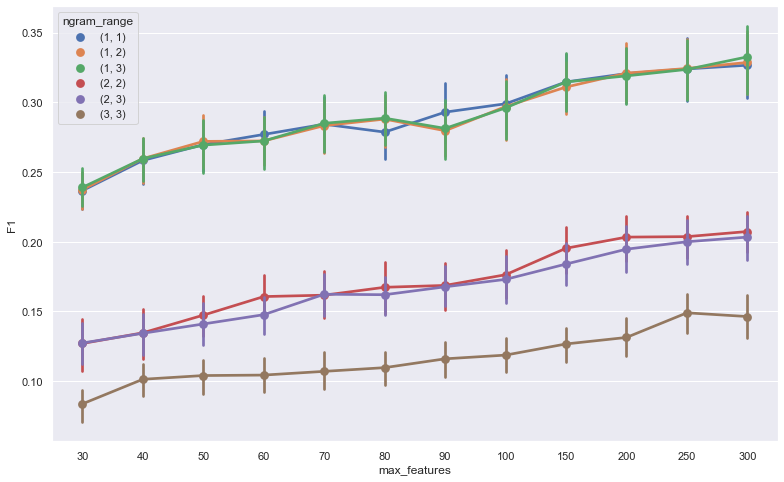

In [52]:
# Exploding DataFrame of lists to proper pandas DataFrames
scores = ['Accuracy', 'Recall', 'Precision', 'F1']
results_exploded = results.explode(scores, ignore_index=True)

plt.figure(figsize=(13, 8))
sns.pointplot(x='max_features', y='F1', data=results_exploded, hue='ngram_range')
plt.show()

# TPOT

In [12]:
# Path to save progress of tpot
path_to_memory = os.path.join('..', 'models', 'tpot')
path_to_tpot_model = os.path.join('..', 'models', 'tpot_model.py')

# Best features from previous experiment
best_params = {'ngram_range': (1, 3), 'max_features': 300}
# Processing X_train dataframe
tfidf = TfidfVectorizer(**best_params)
X_tfidf = tfidf.fit_transform(X_train).toarray()

# Encoding labels
label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)

In [13]:
# Shape of processed X_tfidf
X_tfidf.shape

(5028, 300)

In [16]:
tpot_classifier = TPOTClassifier(generations=50, 
                                 population_size=30, 
                                 scoring='f1_weighted',
                                 cv=5,
                                 random_state=42, 
                                 verbosity=2,
                                 n_jobs=-1,
                                 max_eval_time_mins=10,    # tpot has 10 mins to evaluate model
                                 memory=path_to_memory,    # Saving progress in case interuption
                                 early_stop=5)             # If results don't improve over 5 generations then escape

In [17]:
tpot_classifier.fit(X_tfidf, y_train_le)

Optimization Progress:   0%|          | 0/1530 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.38202726757089955

Generation 2 - Current best internal CV score: 0.3842497095372507

Generation 3 - Current best internal CV score: 0.38634661528725023

Generation 4 - Current best internal CV score: 0.39124281763484936

Generation 5 - Current best internal CV score: 0.3930641196695883

Generation 6 - Current best internal CV score: 0.39973478173615623

Generation 7 - Current best internal CV score: 0.39973478173615623

Generation 8 - Current best internal CV score: 0.39973478173615623

Generation 9 - Current best internal CV score: 0.39973478173615623

Generation 10 - Current best internal CV score: 0.40103172585779345

Generation 11 - Current best internal CV score: 0.40213337527020776

Generation 12 - Current best internal CV score: 0.4029053349765399

Generation 13 - Current best internal CV score: 0.4056471334216575

Generation 14 - Current best internal CV score: 0.4056471334216575

Generation 15 - Current best internal CV score:

TPOTClassifier(early_stop=5, generations=50, max_eval_time_mins=10,
               memory='..\\models\\tpot', n_jobs=-1, population_size=30,
               random_state=42, scoring='f1_weighted', verbosity=2)

In [18]:
# Saving best pipeline from TPOT
tpot_classifier.export(path_to_tpot_model)

# Evaluation

In [19]:
# Processing X_test dataframe
X_test = X_test['tokens_lemma'].apply(lambda x: ' '.join(x))
X_test_tfidf = tfidf.transform(X_test).toarray()
# Encoding test labels
y_test_le = label_encoder.transform(y_test)

In [20]:
tpot_classifier.score(X_test_tfidf, y_test_le)

0.400685874207198